### Working through chapter 8 of Deep Learning with Pytorch book.

If you follow through this notebook, it will present you with basic of CNN, as in the nitty gritty detail of shapes of layers, why maxpooling, creating your own model from scratch etc.

![](https://th.bing.com/th/id/R2dcc41f9079d1abf5883a113c0d1ca31?rik=i3uC2F68Rj8a6w&riu=http%3a%2f%2fpytorch.org%2ftutorials%2f_images%2fcifar10.png&ehk=25wY39EtQMRbUWi0278TX3wGQjI11w6Uxr732%2fd0C%2bA%3d&risl=&pid=ImgRaw)

Here we will be using a simple Convolutional Neural Network to work with CIFAR 10 data. To keep things simple we would be using a subset of two classes in cifar dataset. We will be recognising between airoplane and a bird.

We will be using convolutional neural network here. For creating , we’ll resort to nn.Conv2d. 

At a minimum, the arguments we provide to nn.Conv2d are the number of input features (or channels, since we’re dealingwith multichannel images: that is, more than one value per pixel), the number of output features, and the size of the kernel. For instance, for our first convolutional module,

we’ll have 3 input features per pixel (the RGB channels) and an arbitrary number of
channels in the output—say, 16. Also, because we are randomly initializing them, some of the features we’ll
get, even after training, will turn out to be useless.

Let’s stick to a kernel size of 3 × 3.

![](https://cdn-images-1.medium.com/max/1200/1*1okwhewf5KCtIPaFib4XaA.gif)

It is very common to have kernel sizes that are the same in all directions, so
PyTorch has a shortcut for this: whenever kernel_size=3 is specified for a 2D convolution, it means 3 × 3 (provided as a tuple (3, 3) in Python)

In [1]:
import torch.nn as nn

In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

### About the size of the kernel

What do we expect to be the shape of the weight tensor? The kernel is of size 3 × 3, so we want the weight to consist of 3 × 3 parts. 

For a single output pixel value, our kernel
would consider, say, in_ch = 3 input channels, so the weight component for a single
output pixel value (and by translation the invariance for the entire output channel) is
of shape in_ch × 3 × 3. 

Finally, we have as many of those as we have output channels,
here out_ch = 16, so the complete weight tensor is out_ch × in_ch × 3 × 3, in our case
16 × 3 × 3 × 3. 

The bias will have size 16 (we haven’t talked about bias for a while for
simplicity, but just as in the linear module case, it’s a constant value we add to each
channel of the output image). Let’s verify our assumptions:

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

### Lets get the cifar triaining and validation set now

Remember our final aim for getting the dataset is to recognise between a plane and a bird.

In [4]:
from torchvision import datasets

In [5]:
from torchvision import transforms

We will work on a limited dataset, recognising between an aeroplane and a bird. But even for that first we download the entire dataset:

In [6]:
data_path = "./"

In [7]:
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
]) )

|          | 0/? [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [8]:
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
]) )

Files already downloaded and verified


Now we need a subset of the database.if you see the original dataset has labels for aeroplane and bird as 0 and 2.

In [9]:
cifar10.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

we need to convert that into 0 and 1

In [10]:
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']

now lets get the dataset

In [11]:
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]

In [12]:
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

The data is ready to go. Lets work on our model.

### why should we be using Convolutional neural networks anyway

We can see how convolutions are a convenient choice for learning from images.

We have smaller models looking for local patterns whose weights are optimized across the entire image.

A 2D convolution pass produces a 2D image as output, whose pixels are a weighted sum over neighborhoods of the input image. In our case, both the kernel weights and the bias conv.weight are initialized randomly, so the output image will not be particularly meaningful. As usual, we need to add the zeroth batch dimension with
unsqueeze if we want to call the conv module with one input image, since nn.Conv2d
expects a B × C × H × W shaped tensor as input:

B is batch size
C is color
H is Height
W is Width


In [13]:
img, _ = cifar2[0]

output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

note the output shape here is different to input shape. Can you guess how?

In [14]:
import matplotlib.pyplot as plt

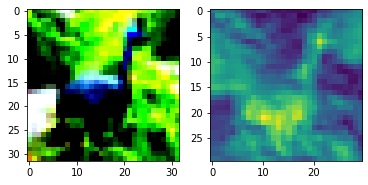

In [15]:
fig  = plt.figure()
fig.add_subplot(1,2,1 )
plt.imshow(img.permute(1,2,0))
fig.add_subplot(1,2,2)
plt.imshow(output[0,0].detach())
plt.show()

### output shape != input shape

The fact that our output image is smaller than the input is a side effect of deciding what
to do at the boundary of the image.

Applying a convolution kernel as a weighted sum
of pixels in a 3 × 3 neighborhood requires that there are neighbors in all directions.

If we are at i00, we only have pixels to the right of and below us. By default, PyTorch will
slide the convolution kernel within the input picture, getting width - kernel_width +1
horizontal and vertical positions. For odd-sized kernels, this results in images that are one-half the convolution kernel’s width (in our case, 3//2 = 1) smaller on each side.

This explains why we’re missing two pixels in each dimension.


### Padding the boundary

However, PyTorch gives us the possibility of padding the image by creating ghost pixels around the border that have value zero as far as the convolution is concerned.

 In our case, specifying padding=1 when kernel_size=3 means i00 has an extra set
of neighbors above it and to its left, so that an output of the convolution can be computed even in the corner of our original image.

The net result is that the output has
now the exact same size as the input:


In [16]:
conv = nn.Conv2d(3,1,kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

Doing padding helps us separate the matters of convolution and changing image sizes, so we have one less thing to
remember. 

![](https://images.deepai.org/glossary-terms/5361a0e82d3941e58903b90f64e71491/download.png)

### Detecting features with convolution

We said earlier that weight and bias are parameters that are learned through backpropagation, exactly as it happens for weight and bias in nn.Linear. 

However, we can play with convolution by setting weights by hand and see what happens.

Let’s first zero out bias, just to remove any confounding factors, and then set weights to a constant value so that each pixel in the output gets the mean of its neighbors. For each 3 × 3 neighborhood

In [17]:
import torch

In [18]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0/ 9.0)
    

### what weights and bias

We could have gone with conv.weight.one_()— that would result in each pixel in the
output being the sum of the pixels in the neighborhood. Not a big difference, except that the values in the output image would have been nine times larger.

Anyway, let’s see the effect on our CIFAR image:

Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.


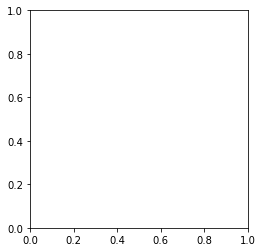

In [19]:
try:
    output = conv(img.unsqueeze(0))
    plt.imshow(output[0,0])
    plt.show()
except Exception as e:
    print(e)

So we need to call detach on the output

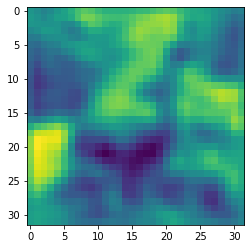

In [20]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach())
plt.show()

It looks like a blob of a skeleton rising from a swamp. 

In [21]:
conv = nn.Conv2d(3,1,kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0,0.0,1.0],[-1.0,0.0,1.0],[-1.0,0.0,1.0]])
    conv.bias.zero_()

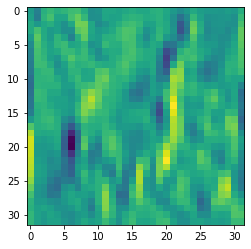

In [22]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach())
plt.show()

This convolution is supposed to enhance the vertical edges of images.

### Looking further with depth and pooling


This is all well and good, but conceptually there’s an elephant in the room. We got all excited because by moving from fully connected layers to convolutions, we achieve
locality and translation invariance.

Then we recommended the use of small kernels, like 3 × 3, or 5 × 5: that’s peak locality, all right. What about the big picture?

How do we know that all structures in our images are 3 pixels or 5 pixels wide? Well, we don’t,
because they aren’t. And if they aren’t, how are our networks going to be equipped to
see those patterns with larger scope?

This is something we’ll really need if we want to solve our birds versus airplanes problem effectively, since although CIFAR-10 images
are small, the objects still have a (wing-)span several pixels across.

One possibility could be to use large convolution kernels. Well, sure, at the limit we
could get a 32 × 32 kernel for a 32 × 32 image, but we would converge to the old fully
connected, affine transformation and lose all the nice properties of convolution.

Another option, which is used in convolutional neural networks, is stacking one convolution after the other and at the same time downsampling the image between successive convolutions.

### Downsampling

Scaling the image by half is equivalent of taking four neighboring pixels and producing one pixel.

we could:

1. Average the four pixels

2. Take the maximim of th efout pixels

3. Perform a strided convolution where every nth pixel is calculated

### Maxpooling

Intuitively, the output images form a convolution layer, especially since they are followed by an activation just like any other linear layer, they tend to have a high magnitude, where certain features corresponding to the estimated kernel are detected, such as vertical lines.

By taking the highest value we ensure that features are found to survive the downsampling

In [23]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

### Combining convolutions and downsampling

Lets see how to use it on larger structures. We start by applying a set of 3 × 3 kernels on our 8 × 8
image, obtaining a multichannel output image of the same size. 

Then we scale down the output image by half, obtaining a 4 × 4 image, and apply another set of 3 × 3 kernels to it. This second set of kernels operates on a 3 × 3 neighborhood of something that has been scaled down by half, so it effectively maps back to 8 × 8 neighborhoods
of the input. 

In addition, the second set of kernels takes the output of the first set of
kernels (features like averages, edges, and so on) and extracts additional features on
top of those.

So, on one hand, the first set of kernels operates on small neighborhoods on firstorder, low-level features, while the second set of kernels effectively operates on wider
neighborhoods, producing features that are compositions of the previous features.

This is a very powerful mechanism that provides convolutional neural networks with
the ability to see into very complex scenes—much more complex than our 32 × 32
images from the CIFAR-10 dataset. 

### Putting it together for our network

With these building blocks in our hands, we can now proceed to build our convolutional neural network for detecting birds and airplanes. 

Let’s take our previous fully
connected model as a starting point and introduce nn.Conv2d and nn.MaxPool2d as
described previously:

In [24]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2), # converts 32 by 32 to 16 by 16
            nn.Conv2d(16,8,kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
    
            # something missing
            # to be filled later
            # we need a reshaping block here
    
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32,2)
    
)

### looking into the convolutions

You dont need to read the explanation in this para, just scroll down where I define my own model and look at the model output to inspect the intermediate sizes.

The first convolution takes us from 3 RGB channels to 16, thereby giving the network a chance to generate 16 independent features that operate to (hopefully) discriminate low-level features of birds and airplanes. 

Then we apply the Tanh activation function. The resulting 16-channel 32 × 32 image is pooled to a 16-channel 16 × 16 image by the first MaxPool3d.

At this point, the downsampled image undergoes another convolution that generates an 8-channel 16 × 16 output.

With any luck, this output will consist of higher-level features. Again, we apply a Tanh activation and then pool to an
8-channel 8 × 8 output.

Where does this end? After the input image has been reduced to a set of 8 × 8 features, we expect to be able to output some probabilities from the network that we can
feed to our negative log likelihood.

However, probabilities are a pair of numbers in a
1D vector (one for airplane, one for bird), but here we’re still dealing with multichannel 2D features.

Thinking back to the beginning of this chapter, we already know what we need to
do: turn the 8-channel 8 × 8 image into a 1D vector and complete our network with a
set of fully connected layers:

In [25]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list) , numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

That’s very reasonable for a limited dataset of such small images. 

In order to increase the capacity of the model, we could increase the number of output channels for the
convolution layers (that is, the number of features each convolution layer generates), which would lead the linear layer to increase its size as well.

We put the “Warning” note in the code for a reason. The model has zero chance of running without complaining

In [26]:
try:
    model(img.unsqueeze(0))
except Exception as e:
    print(e)

mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)


### The error of our ways

Admittedly, the error message is a bit obscure, but not too much so. We find references to linear in the traceback: looking back at the model, we see that only module
that has to have a 512 × 32 tensor is nn.Linear(512, 32), the first linear module after
the last convolution block.

What’s missing there is the reshaping step from an 8-channel 8 × 8 image to a 512-
element, 1D vector (1D if we ignore the batch dimension, that is). 

This could be achieved by calling view on the output of the last nn.MaxPool2d, but unfortunately, we
don’t have any explicit visibility of the output of each module when we use nn.Sequential.

### Subclassing nn.Module

At some point in developing neural networks, we will find ourselves in a situation where
we want to compute something that the premade modules do not cover. Here, it is something very simple like reshaping. 

When we want to build models that do more complex things than just applying
one layer after another, we need to leave nn.Sequential for something that gives us
added flexibility. PyTorch allows us to use any computation in our model by subclassing nn.Module.

In order to subclass nn.Module, at a minimum we need to define a forward function that takes the inputs to the module and returns the output. This is where we define our
module’s computation. 

With PyTorch, if we use standard torch operations, autograd will take care of the backward pass automatically; and indeed, an nn.Module never comes with a backward.

Typically, our computation will use other modules—premade like convolutions or
customized. To include these submodules, we typically define them in the constructor
__init__ and assign them to self for use in the forward function. They will, at the
same time, hold their parameters throughout the lifetime of our module. Note that you
need to call super().__init__() before you can do that (or PyTorch will remind you).

### Our network as an nn.Module

In [27]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.debug = True
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32,2)
    
    def forward(self, x):
        if (self.debug):
            print("0 input shape : ", x.shape)
            out = self.conv1(x)
            print("1 after convolution : ", self.conv1, "\n", out.shape, "\n")

            out = self.act1(out)
            print("2 after activation : ", self.act1, "\n", out.shape, "\n")

            out = self.pool1(out)
            print("3 after Maxpooling : ",self.pool1, "\n", out.shape, "\n")

            out = self.conv2(out)
            print("4 after convolution : ",self.conv2, "\n", out.shape, "\n")
            
            out = self.act2(out)
            print("5 after activation : ", self.act2, "\n" ,out.shape, "\n")
            
            out = self.pool2(out)
            print("6 after maxpooling : ", self.pool2, "\n", out.shape, "\n")
            
            out = out.view(-1, 8 * 8 * 8)
            print("> converting into out.view(-1, 8 * 8 * 8) : ", "\n", out.shape, "\n")
            
            out = self.fc1(out)
            print("7 after Linear affine transformation : ", self.fc1, "\n", out.shape, "\n")
            
            out = self.act3(out)
            print("8 after activation : ", self.act3, "\n", out.shape, "\n")
            
            out = self.fc2(out)
            print("9 after Linear affine transformation : ", self.fc2, "\n", out.shape, "\n")
            
            return out

In [28]:
model = Net()

output = model(img.unsqueeze(0))
print(output)
# plt.imshow(output[0,0].detach())
# plt.show()

0 input shape :  torch.Size([1, 3, 32, 32])
1 after convolution :  Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
 torch.Size([1, 16, 32, 32]) 

2 after activation :  Tanh() 
 torch.Size([1, 16, 32, 32]) 

3 after Maxpooling :  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
 torch.Size([1, 16, 16, 16]) 

4 after convolution :  Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 
 torch.Size([1, 8, 16, 16]) 

5 after activation :  Tanh() 
 torch.Size([1, 8, 16, 16]) 

6 after maxpooling :  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) 
 torch.Size([1, 8, 8, 8]) 

> converting into out.view(-1, 8 * 8 * 8) :  
 torch.Size([1, 512]) 

7 after Linear affine transformation :  Linear(in_features=512, out_features=32, bias=True) 
 torch.Size([1, 32]) 

8 after activation :  Tanh() 
 torch.Size([1, 32]) 

9 after Linear affine transformation :  Linear(in_features=32, out_features=2, bias=True) 
 torch.Size

### Discussion on the model

The Net class is equivalent to the nn.Sequential model
we built earlier in terms of submodules; but by writing
the forward function explicitly, we can manipulate the
output of self.pool3 directly and call view on it to turn
it into a B × N vector.

Note that we leave the batch dimension as –1 in the call to view, since in principle we
don’t know how many samples will be in the batch.

We are making some ad hoc choices about what information to present where.
Recall that the goal of classification networks typically is to compress information in the sense that we
start with an image with a sizable number of pixels and compress it into (a vector of probabilities of) classes.

### How pytorch keeps track of parameters and submodules

Interestingly, assigning an instance of nn.Module to an attribute in an nn.Module, as
we did in the earlier constructor, automatically registers the module as a submodule.

The submodules must be top-level attributes, not buried inside list or
dict instances! Otherwise the optimizer will not be able to locate the submodules (and, hence, their parameters). For situations where your model
requires a list or dict of submodules, PyTorch provides nn.ModuleList and
nn.ModuleDict


### can we have arbitrary functions ?

Yes, We can call arbitrary methods of an nn.Module subclass. For example, for a model
where training is substantially different than its use, say, for prediction, it may make
sense to have a predict method. Be aware that calling such methods will be similar to
calling forward instead of the module itself—they will be ignorant of hooks, and the
JIT does not see the module structure when using them because we are missing the
equivalent of the __call__ bits shown in section

In [29]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

### how parameters are found 

What happens here is that the parameters() call delves into all submodules assigned
as attributes in the constructor and recursively calls parameters() on them. No matter how nested the submodule, any nn.Module can access the list of all child parameters. By accessing their grad attribute, which has been populated by autograd, the
optimizer will know how to change parameters to minimize the loss

### The functional API

PyTorch has functional counterparts for every nn module.
By “functional” here we mean “having no internal state”—in other words, “whose output value is solely and fully determined by the value input arguments.” 

Indeed, torch.nn.functional provides many functions that work like the modules we find in nn.
But instead of working on the input arguments and stored parameters like the module counterparts, they take inputs and parameters as arguments to the function call.

For instance, the functional counterpart of nn.Linear is nn.functional.linear,
which is a function that has signature linear(input, weight, bias=None). The
weight and bias parameters are arguments to the function.

Back to our model, it makes sense to keep using nn modules for nn.Linear and
nn.Conv2d so that Net will be able to manage their Parameters during training. However, we can safely switch to the functional counterparts of pooling and activation,
since they have no parameters:



In [30]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32,2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

### To use or not to use functional API

Whether to use the functional or the modular API is a decision based on style and
taste. When part of a network is so simple that we want to use nn.Sequential, we’re in
the modular realm. When we are writing our own forwards, it may be more natural to
use the functional interface for things that do not need state in the form of parameters.

 So now we can make our own nn.Module if we need to, and we also have the functional API for cases when instantiating and then calling an nn.Module is overkill. This
has been the last bit missing to understand how the code organization works in just
about any neural network implemented in PyTorch.

In [31]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.1441, 0.1464]], grad_fn=<AddmmBackward>)

We got two numbers! Information flows correctly. We might not realize it right now,
but in more complex models, getting the size of the first linear layer right is sometimes a source of frustration. We’ve heard stories of famous practitioners putting in
arbitrary numbers and then relying on error messages from PyTorch to backtrack the
correct sizes for their linear layers. Lame, eh? Nah, it’s all legit!

### Training our Convnet

The core of our convnet is two nested loops: an outer one over the
epochs and an inner one of the DataLoader that produces batches from our Dataset.

In each loop, we then have to

1. Feed the inputs through the model (the forward pass).
2. Compute the loss (also part of the forward pass).
3. Zero any old gradients.
4. Call loss.backward() to compute the gradients of the loss with respect to all
parameters (the backward pass).
5. Have the optimizer take a step in toward lower loss.

Also, we collect and print some information

In [32]:
import torch.optim as optim

In [33]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        
        for imgs, labels in train_loader:
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels) # the loss we wish to minimise
            optimizer.zero_grad() # getting rid of gradients from last round
            loss.backward() # performs the backward step, we computer the gradients of all parameters we want the network to learn
            optimizer.step() # updates the model
            loss_train += loss.item()
            
        if epoch == 1 or epoch %10 == 0:
            print('{} Epoch {}, training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [34]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)


In [35]:
model = Net()

In [36]:
optimizer = optim.SGD(model.parameters(), lr = 1e-2)


In [37]:
loss_fn = nn.CrossEntropyLoss()

In [38]:
training_loop(
    n_epochs = 10, # change it to 100 for better values
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2021-03-12 00:38:47.341185 Epoch 1, training loss 0.5962967589782302
2021-03-12 00:39:12.928275 Epoch 10, training loss 0.332811221195634


## Measuring accuracy

In order to have an accuracy more interpretable thatn the loss we can take alookat our accuracies on the training and validation datasets

In [39]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

In [40]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad(): # since we dont want to update the parameters
            
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # index of highest value as output
                total += labels.shape[0] # counts the number of examples so total is increased by the batch size
                correct += int((predicted == labels).sum())
                # Comparing the predicted class that had the
                # maximum probability and the ground-truth
                # labels, we first get a Boolean array. Taking the
                # sum gives the number of items in the batch
                # where the prediction and ground truth agree.
                
            print("Accuracy {}: {:.2f}".format(name, correct/total))

In [41]:
validate(model, train_loader, val_loader)

Accuracy train: 0.86
Accuracy val: 0.85


### how to save your model

Its pretty easy to do, we will store it in birds_vs_airplanes.pt. The thing isonyl weight is stored

In [42]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

While loading we need to give the structure of the model.

In [43]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

### Note about training on the GPU

There is a somewhat subtle difference between Module.to and Tensor.to.
Module.to is in place: the module instance is modified. But Tensor.to is out of place
(in some ways computation, just like Tensor.tanh), returning a new tensor. One
implication is that it is good practice to create the Optimizer after moving the parameters to the appropriate device.

 It is considered good style to move things to the GPU if one is available. A good
pattern is to set the a variable device depending on torch.cuda.is_available:

In [44]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print("Training on ", device)

Training on  cuda


### Amending the training loop to cater for GPU




In [45]:
def training(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print( '{} epoch {}, training loss {}'.format(
                datetime.datetime.now(), epoch, loss_train / len(train_loader)
            ))

In [46]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [47]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

try:
    training_loop(
        n_epochs = 100,
        optimizer = optimizer,
        model = model,
        loss_fn = loss_fn,
        train_loader= train_loader
    )
except Exception as e:
    print(e)

Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same


https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte

### Model design

We can add the width of the network or the number of neurons per layer. we can increase te number of channels starting from first convolution

In [48]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(Self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

We can easily pass a parameter to init and parameterize the width taking care to also paramterize the call to view in the forward function

In [49]:
class Netwidth(nn.Module):
    def __init__(self, n_chans1=32):
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32,2)
    
    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*self.n_chans1//2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Lets look at the number of parameters of the model

In [50]:
sum(p.numel() for p in model.parameters())

18090

greater the capacity more variability but also might lwad to overfitting.

### Helping model to converge and regularize

1. keeping the parameters in check

Adding a regularisation termto the loss. This term is crafted so that the weights of the model tend to be small on their own, limiting how much training makes themgrow. In otherwords it is a penalty on larger weight values. 

There are again 2 
> L1 regularisation which is the sum of absolute values of all weights in the model

> L2 regularisation which is the sum of squared of all the weights in the model. Also called weight decay.

So it punishes having more weights in the model. regularisation is added by using a term in the loss

In [51]:
def training_loop_l2reg(n_epochs,optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        
        if epoch ==1 or epoch %10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train /len(train_loader)))


it is worth noting that the SGD optimizer in PyTorch already has a weight_decay parameter that
corresponds to 2 * lambda, and it directly performs weight decay during the update
as described previously. 

### using Dropout without relying on a single input

Zero out a random fraction of outputs from neurons accross network where randomisation happens at each iteration.

In [52]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32, debug=False):
        self.debug = debug
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout3d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32,2)
    
    def forward(self, x):
        if (self.debug == False ):
            out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
            out = self.conv1_dropout(out)
            out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
            out = self.conv2_dropout(out)
            out = out.view(-1,8*8*self.n_chans1//2)
            out = torch.tanh(self.fc1(out))
            out = self.fc2(out)
            return out
        
        else:
            print("X shape: ", x.shape, "\n")
            out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
            print("After 1st convolution: ", out.shape)
            out = self.conv1_dropout(out)
            print("After 1st dropout: ", out.shape)
            out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
            print("After 2nd convolution: ", out.shape)
            out = self.conv2_dropout(out)
            print("After 2nd dropout: ", out.shape)
            out = out.view(-1,8*8*self.n_chans1//2)
            print("After flattening: ", out.shape)
            out = torch.tanh(self.fc1(out))
            print("After 1st linear: ", out.shape)
            out = self.fc2(out)
            print("result shape: ", out.shape)
            return out
            

In [53]:
model = NetDropout(debug=True)

output = model(img.unsqueeze(0))
print(output)


X shape:  torch.Size([1, 3, 32, 32]) 

After 1st convolution:  torch.Size([1, 32, 16, 16])
After 1st dropout:  torch.Size([1, 32, 16, 16])
After 2nd convolution:  torch.Size([1, 16, 8, 8])
After 2nd dropout:  torch.Size([1, 16, 8, 8])
After flattening:  torch.Size([1, 1024])
After 1st linear:  torch.Size([1, 32])
result shape:  torch.Size([1, 2])
tensor([[ 0.1265, -0.2325]], grad_fn=<AddmmBackward>)


Note that dropout is only active during training and it is taken as zero in all subsequent run. This is controlled through the train property of the dropout 

this is achieved through `model.train()` and `model.eval()`
on any of the nn.Model subclass.

### Batch Normalisation for keeping activations in check


Main idea is to rescale the inputs to the activations of the network so that minibatches have a certain desirable distibution. In practice it shifts and scales an intermediate input using the mean and standard deviation collected at that intermediate location over the samples of minibatch.

 Batch normalization in PyTorch is provided through the nn.BatchNorm1D,
nn.BatchNorm2d, and nn.BatchNorm3d modules, depending on the dimensionality of
the input. Since the aim for batch normalization is to rescale the inputs of the activations, the natural location is after the linear transformation (convolution, in this case)
and the activation, as shown here:

In [54]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1//2)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32,2)
    
    def forward(self, x):
        print("input shape ",x.shape)
        out = self.conv1(x)
        print("before batch normalisation " , out.shape)
        out = self.conv1_batchnorm(out)
        print("after batch normalisation ", out.shape)
        out = F.max_pool2d(torch.tanh(out), 2)
        print("after max pooling over activations ", out.shape)
        out = self.conv2_batchnorm(self.conv2(out))
        print("after convolution and batchnorm ", out.shape)
        out = F.max_pool2d(torch.tanh(out), 2)
        print("after maxpooling ", out.shape)
        out = out.view(-1, 8*8*self.n_chans1 //2)
        print("flattening ", out.shape)
        out = torch.tanh(self.fc1(out))
        print("activation over linear 1 ",out.shape)
        out =self.fc2(out)
        print("activation over linear 2 ",out.shape)
        return out

In [55]:
model = NetBatchNorm()

output = model(img.unsqueeze(0))
print(output)

input shape  torch.Size([1, 3, 32, 32])
before batch normalisation  torch.Size([1, 32, 32, 32])
after batch normalisation  torch.Size([1, 32, 32, 32])
after max pooling over activations  torch.Size([1, 32, 16, 16])
after convolution and batchnorm  torch.Size([1, 16, 16, 16])
after maxpooling  torch.Size([1, 16, 8, 8])
flattening  torch.Size([1, 1024])
activation over linear 1  torch.Size([1, 32])
activation over linear 2  torch.Size([1, 2])
tensor([[-0.3531,  0.0120]], grad_fn=<AddmmBackward>)


similar to dropout batch normalisation also behaves differnetly 

## Going deeper and learning more complex structures : Depth

There’s another way to think about depth: increasing depth is related to increasing
the length of the sequence of operations that the network will be able to perform
when processing input

Depth comes with some additional challenges, which prevented deep learning models
from reaching 20 or more layers until late 2015. Adding depth to a model generally
makes training harder to converge. 

The derivatives of the loss function with respect to
the parameters, especially those in early layers, need to be multiplied by a lot of other
numbers originating from the chain of derivative operations between the loss and the
parameter. Those numbers being multiplied could be small, generating ever-smaller
numbers, or large, swallowing smaller numbers due to floating-point approximation.
The bottom line is that a long chain of multiplications will tend to make the contribution of the parameter to the gradient vanish, leading to ineffective training of that layer
since that parameter and others like it won’t be properly updated.




### Skip connections

A skip connection is nothing but
the addition of the input to the output
of a block of layers. This is exactly how
it is done in PyTorch. Let’s add one
layer to our simple convolutional
model, and let’s use ReLU as the activation for a change. The vanilla module with an extra layer looks like this

In [56]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1//2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*n_chans1//2, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4*4*self.n_chans1//2)
        out = torch.relu(self.fc1(out))
        return out
        

In [57]:
model = NetRes()

output = model(img.unsqueeze(0))
print(output)

tensor([[0.0470, 0.0000, 0.1109, 0.1501, 0.2204, 0.0000, 0.0000, 0.0563, 0.0000,
         0.0000, 0.1085, 0.0000, 0.1908, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0723, 0.0931, 0.0000, 0.0000, 0.0000, 0.0999, 0.0000, 0.1844,
         0.0000, 0.2450, 0.0890, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)


In other words, we’re using the output of the first activations as inputs to the last, in
addition to the standard feed-forward path. This is also referred to as identity mapping.
So, how does this alleviate the issues with vanishing gradients we were mentioning
earlier?
 Thinking about backpropagation, we can appreciate that a skip connection, or a
sequence of skip connections in a deep network, creates a direct path from the deeper
parameters to the loss. This makes their contribution to the gradient of the loss more
direct, as partial derivatives of the loss with respect to those parameters have a chance
not to be multiplied by a long chain of other operations.

In [58]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        # bias is false because Batch norm will cancel the effect of bias
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        # Uses custom initializations
        # . kaiming_normal_ initializes with
        # normal random elements with standard
        # deviation as computed in the ResNet paper.
        # The batch norm is initialized to produce output
        # distributions that initially have 0 mean and 0.5 varianc
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        return out + x

In init we create nn.sequential containing a list of nn.sequential containing a list of RsBlock instances. nn.Sequentil will ensure that the output of one block is used as the input to the next. It will also ensure that allthe parameters in the block are visibele to Net.

then in forwardwe traverse it 100 times

In [72]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3,padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear( 8*8*n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(1, 8*8*self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [73]:
model = NetResDeep()
output = model(img.unsqueeze(0))
print(output)

tensor([[-0.7498, -0.5627]], grad_fn=<AddmmBackward>)


### slowed down convergence

In the implementation, we parameterize the actual number of layers, which is important for experimentation and reuse. Also, needless to say, backpropagation will work as
expected. Unsurprisingly, the network is quite a bit slower to converge.

e. This is why we used more-detailed initializations and trained
our NetRes with a learning rate of 3e – 3 instead of the 1e – 2 we used for the other
networks. We trained none of the networks to convergence, but we would not have
gotten anywhere without these tweaks.

### Initialisation

Initialisation is a running problem with training neural network in pytorch. We found that our model did not converge and looked
at what people commonly choose as initialization (a smaller variance in weights; and
zero mean and unit variance outputs for batch norm), and then we halved the output
variance in the batch norm when the network would not converge.

## Conclusion

 In this chapter, we have built reasonable, working models in PyTorch that can
learn from images. We did it in a way that helped us build our intuition around convolutional networks. We also explored ways in which we can make our models wider and
deeper, while controlling effects like overfitting. Although we still only scratched the
surface, we have taken another significant step ahead from the previous chapter. We
now have a solid basis for facing the challenges we’ll encounter when working on
deep learning projects.`

## extra bits : Exercises

Change our model to use a 5 × 5 kernel with kernel_size=5 passed to the
nn.Conv2d constructor.

In [109]:
class NetDropoutMod(nn.Module):
    def __init__(self, n_chans1=64,k_size=5,k_pad=2, debug=False):
        self.debug = debug
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=k_size, padding=k_pad)
        self.conv1_dropout = nn.Dropout3d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=k_size, padding=k_pad)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32,2)
    
    def forward(self, x):
        if (self.debug == False ):
            out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
            out = self.conv1_dropout(out)
            out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
            out = self.conv2_dropout(out)
            out = out.view(-1,8*8*self.n_chans1//2)
            out = torch.tanh(self.fc1(out))
            out = self.fc2(out)
            return out
        
        else:
            print("X shape: ", x.shape, "\n")
            out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
            print("After 1st convolution: ", self.conv1, " : ", out.shape)
            out = self.conv1_dropout(out)
            print("After 1st dropout: ", out.shape)
            out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
            print("After 2nd convolution: ", self.conv2, " : ", out.shape)
            out = self.conv2_dropout(out)
            print("After 2nd dropout: ", out.shape)
            out = out.view(-1,8*8*self.n_chans1//2)
            print("After flattening: ", out.shape)
            out = torch.tanh(self.fc1(out))
            print("After 1st linear: ", out.shape)
            out = self.fc2(out)
            print("result shape: ", out.shape)
            return out
            

In [110]:
model = NetDropoutMod(debug=True)

output = model(img.unsqueeze(0))


X shape:  torch.Size([1, 3, 32, 32]) 

After 1st convolution:  Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))  :  torch.Size([1, 64, 16, 16])
After 1st dropout:  torch.Size([1, 64, 16, 16])
After 2nd convolution:  Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))  :  torch.Size([1, 32, 8, 8])
After 2nd dropout:  torch.Size([1, 32, 8, 8])
After flattening:  torch.Size([1, 2048])
After 1st linear:  torch.Size([1, 32])
result shape:  torch.Size([1, 2])


a What impact does this change have on the number of parameters in the
model?

In [93]:
sum([p.numel() for p in model.parameters()])

121730

In [91]:
model2 = NetDropoutMod(k_size=3, k_pad=1)
output = model2(img.unsqueeze(0))

In [96]:
sum([p.numel() for p in model2.parameters()])

85890

Parameters increase with changing the kernel_size of convolutions

In [111]:
model = NetDropoutMod()

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)


2021-03-12 01:59:19.778115 Epoch 1, training loss 0.5356112352222394
2021-03-12 02:01:37.833730 Epoch 10, training loss 0.3453858941793442


In [112]:
validate(model, train_loader, val_loader)

Accuracy train: 0.85
Accuracy val: 0.83


b Does the change improve or degrade overfitting?

Maybe. It is matching closely with val accuracy.

d Can you describe what kernel_size=(1,3) will do?

In [106]:
class NetDropoutKernelMod(nn.Module):
    def __init__(self, n_chans1=64,k_size=5,k_pad=2, debug=False):
        self.debug = debug
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=(1,3), padding=1)
        self.conv1_dropout = nn.Dropout3d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1//2, kernel_size=(1,3), padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32,2)
    
    def forward(self, x):
        if (self.debug == False ):
            out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
            out = self.conv1_dropout(out)
            out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
            out = self.conv2_dropout(out)
            out = out.view(-1,8*8*self.n_chans1//2)
            out = torch.tanh(self.fc1(out))
            out = self.fc2(out)
            return out
        
        else:
            print("X shape: ", x.shape, "\n")
            out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
            print("After 1st convolution: ", self.conv1, " : ", out.shape)
            out = self.conv1_dropout(out)
            print("After 1st dropout: ", out.shape)
            out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
            print("After 2nd convolution: ", self.conv2, " : ", out.shape)
            out = self.conv2_dropout(out)
            print("After 2nd dropout: ", out.shape)
            out = out.view(-1,2304)
            print("After flattening: ", out.shape)
            out = torch.tanh(self.fc1(out))
            print("After 1st linear: ", out.shape)
            out = self.fc2(out)
            print("result shape: ", out.shape)
            return out
            

In [107]:
model = NetDropoutKernelMod(debug=True)

try:
    output = model(img.unsqueeze(0))
except Exception as e:
    print(e)

X shape:  torch.Size([1, 3, 32, 32]) 

After 1st convolution:  Conv2d(3, 64, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))  :  torch.Size([1, 64, 17, 16])
After 1st dropout:  torch.Size([1, 64, 17, 16])
After 2nd convolution:  Conv2d(64, 32, kernel_size=(1, 3), stride=(1, 1), padding=(1, 1))  :  torch.Size([1, 32, 9, 8])
After 2nd dropout:  torch.Size([1, 32, 9, 8])
After flattening:  torch.Size([1, 2304])
mat1 and mat2 shapes cannot be multiplied (1x2304 and 2048x32)


model does not work with this kernel.

2. Finding an image and manually feeding` it into the model.


In [117]:
img, _ = cifar2[1001]

output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

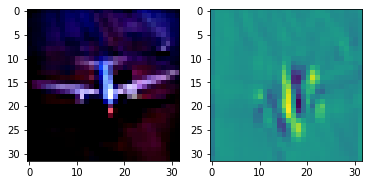

In [118]:
fig  = plt.figure()
fig.add_subplot(1,2,1 )
plt.imshow(img.permute(1,2,0))
fig.add_subplot(1,2,2)
plt.imshow(output[0,0].detach())
plt.show()

In [120]:
output = model(img.unsqueeze(0))
print(output)

# aeroplane

tensor([[ 1.2920, -1.6656]], grad_fn=<AddmmBackward>)


In [123]:
img, _ = cifar2[3001]

output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

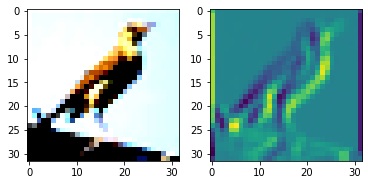

In [124]:
fig  = plt.figure()
fig.add_subplot(1,2,1 )
plt.imshow(img.permute(1,2,0))
fig.add_subplot(1,2,2)
plt.imshow(output[0,0].detach())
plt.show()

In [125]:
output = model(img.unsqueeze(0))
print(output)

# bird

tensor([[-0.8743,  0.4734]], grad_fn=<AddmmBackward>)
